# Tutorial 6 - Inversion of tide gauge data

As a more elaborate application of this library, we now consider the problem of estimate changes to ice sheet thickness from tide gauge measurements. This is done by linking ```pyslfp``` to the ```pygeoinf``` library. 

As a first step we set up an instance of the ```FingerPrint``` class.

In [10]:
# Import necessary libraries. 
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import pygeoinf as inf
from pygeoinf.homogeneous_space.sphere import Sobolev
import pyslfp as sl

# Set up the FingerPrint instance
fingerprint = sl.FingerPrint(
    lmax=128,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fingerprint.set_state_from_ice_ng()


We will not use real tide gauge locations, but rather select a set of points randomly within the oceans. This is done using the following function:

In [11]:
# Function for generating random ocean locations.
def random_ocean_locations(n, lat1=-90, lat2=90):
    """
    Returns a set of n points within the oceans. An optional
    range of latitudes can be provided.
    """
    lats = []
    lons = []
    while len(lats) < n:
        lat = np.random.uniform(lat1, lat2)
        lon = np.random.uniform(-180, 180)
        sl = fingerprint.point_evaulation(fingerprint.sea_level, lat, lon)
        if sl > 0:
            lats.append(lat)
            lons.append(lon)
    return np.array(lats), np.array(lons)

To interface with the ```pygeoinf``` library, we first need to set our model space. This will be $H^{s}(\mathbb{S}^{2})$ for $s > 1$, with this choice of exponent being sufficient for the ice thickness to have well-defined point values. 

In [12]:
# Set the model space for the ice thickness change. 
model_space = Sobolev(
    fingerprint.lmax, 2, 0.1, radius=fingerprint.mean_sea_floor_radius
)

Elements of this space are scalar fields defined over the unit sphere, but we only wish to consider loads associated with a change of ice thickness. This can be acheived by defining first a projection operator that maps such scalar fields by a function that is one over the ice sheets and vanishes elsewhere. Note that such an operator is $L^{2}(\mathbb{S}^{2})$ self-adjoint, and hence it can be generated using the ```formally_self_adjoint``` method for the ```LinearOperator``` class. 

In [13]:
# Set the ice projection operator.
ice_projection = inf.LinearOperator.formally_self_adjoint(
    model_space,
    lambda ice_thickness_change: fingerprint.ice_projection(0) * ice_thickness_change,
)

We can define a further mapping that takes a ice in ice thickness and coverts it into the associated direct load:

In [14]:
# Set the load projection.
load_projection = inf.LinearOperator.formally_self_adjoint(
    model_space, fingerprint.direct_load_from_ice_thickness_change
)

To solve the inverse problem we will use a Bayesian approach, and hence need to define a prior probability distribution. Here we start with a simple invaiant prior which we then push-forward using the ice projection. The result is a prior whose samples are non-zero only over the ice sheets. 

In [15]:
# Set a prior distribution.
model_prior_measure = model_space.sobolev_gaussian_measure(2, 0.05, 1)
model_prior_measure = model_prior_measure.affine_mapping(
    operator= ice_projection
)

We are now in a position to define the forward operator. This maps a change in ice thickness to the change in sea level at the desired locations. The mapping from the direct load to the sea level change is formally self-adjoint and so this can be readily defined as a ```LinearOperator```. Having done this, we then pre-compose it with the ice and load projections to have it act on the correct model space. Finally, we use the point evaluation operator provided within the ```Sobolev``` class to form the forward operator. 

We also require a data error measure that represents observational errors. Errors are assumed for simplicity to be uncorrelated, to have a constant standard deviation and to have zero-expectation. 

With these two terms set, we can then define our forward problem as an instance of ```LinearForwardProblem```. 

In [16]:
# Set the sea level operator.
sea_level_operator = inf.LinearOperator.formally_self_adjoint(
    model_space,
    lambda direct_load: fingerprint(direct_load=direct_load, rtol=1e-9)[0],
)
sea_level_operator = sea_level_operator @ load_projection @ ice_projection

# Set the observation operator.
n = 50
lats, lons = random_ocean_locations(n, lat1=-60, lat2=60)
observation_operator = model_space.point_evaluation_operator(lats, lons)

# Set the forward problem.
forward_operator = observation_operator @ sea_level_operator

# Set the data space.
data_space = forward_operator.codomain

# Set the data error measure. 
data_error_measure = inf.GaussianMeasure.from_standard_deviation(data_space, 0.001)

# Set the forward problem.
forward_problem = inf.LinearForwardProblem(forward_operator, data_error_measure)

Using our prior measure, we can generate a model a its corresponding data (which includes the addition of random observational errors).

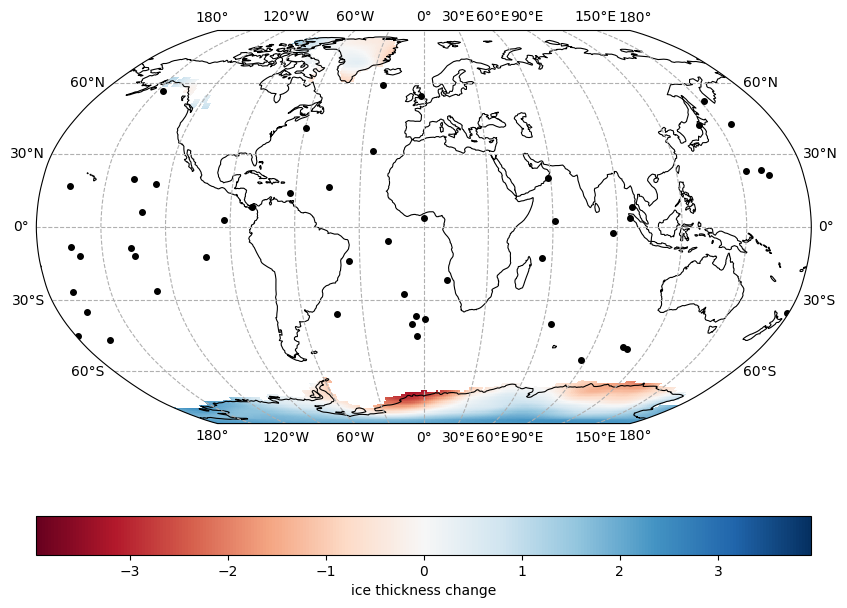

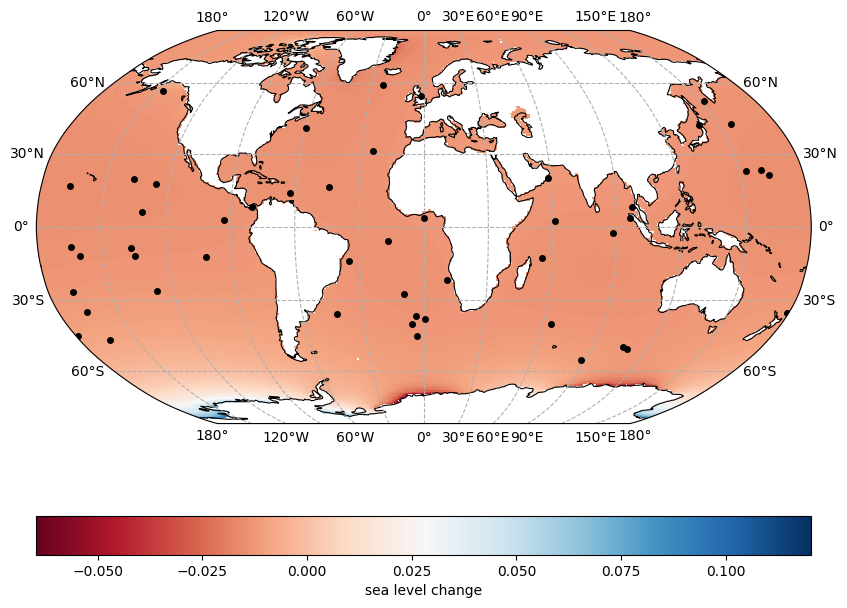

In [17]:
# Generate synthetic data.
model, data = forward_problem.synthetic_model_and_data(model_prior_measure)

# Generate the associated sea level change. 
sea_level_change = sea_level_operator(model)

# Plot the direct load input.
fig, ax, im = sl.plot(model * fingerprint.ice_projection(), symmetric=True)
model_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="ice thickness change")
ax.plot(
    lons,
    lats,
    "o",
    color="k",
    markersize=4,
    transform=ccrs.PlateCarree(),
)

# Plot the resulting sea level
fig, ax, im = sl.plot(sea_level_change * fingerprint.ocean_projection())
sea_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="sea level change")
ax.plot(
    lons,
    lats,
    "o",
    color="k",
    markersize=4,
    transform=ccrs.PlateCarree(),
)

plt.show()


From the forward problem and the model prior, we can set up the inverse problem and then extract the posterior measure:

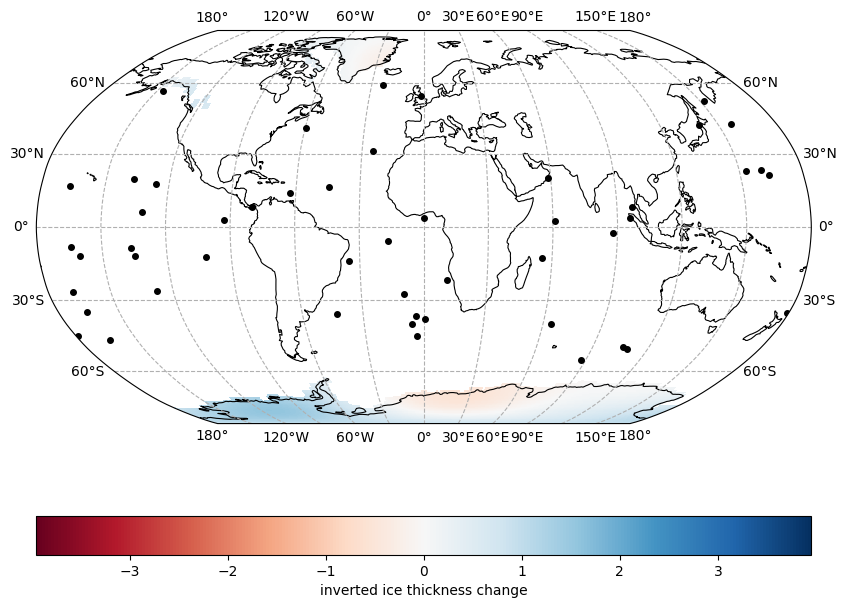

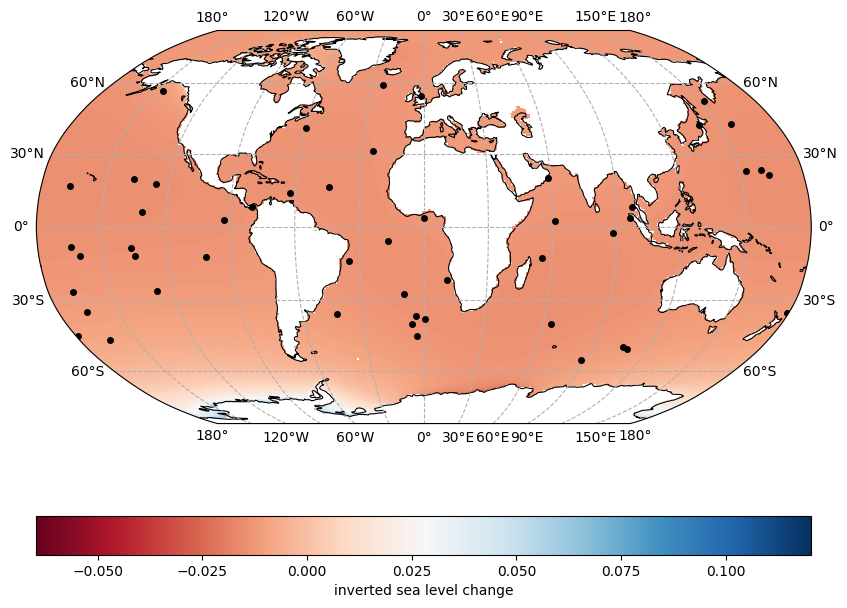

In [19]:
# Set up the inversion
inversion = inf.LinearBayesianInversion(forward_problem, model_prior_measure)

# Invert the data.
model_posterior_measure = inversion.model_posterior_measure(data, inf.CGSolver())
inverted_model = model_posterior_measure.expectation
inverted_sea_level_change = sea_level_operator(inverted_model)


# Plot the inverted direct load input.
fig, ax, im = sl.plot(inverted_model * fingerprint.ice_projection())
im.set_clim(model_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted ice thickness change")
ax.plot(
    lons,
    lats,
    "o",
    color="k",
    markersize=4,
    transform=ccrs.PlateCarree(),
)

# Plot the resulting sea level
fig, ax, im = sl.plot(inverted_sea_level_change * fingerprint.ocean_projection())
im.set_clim(sea_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted sea level change")
ax.plot(
    lons,
    lats,
    "o",
    color="k",
    markersize=4,
    transform=ccrs.PlateCarree(),
)

plt.show()


From the true and inverted models, we can compare the global mean sea level change:

In [20]:
# Get the true change in GMSL
direct_load = load_projection(ice_projection(model))
mean_sea_level_change = fingerprint.mean_sea_level_change(direct_load)
print(f'The true change in mean sea level: {mean_sea_level_change}')


inverted_direct_load = load_projection(ice_projection(inverted_model))
inverted_mean_sea_level_change = fingerprint.mean_sea_level_change(inverted_direct_load)
print(f'The true change in mean sea level: {inverted_mean_sea_level_change}')


The true change in mean sea level: -0.012022485357268329
The true change in mean sea level: -0.011745091401118977
